In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
import json

# Set style for publication-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Color palette for 3-model cascade
COLORS = {
    'baseline': '#3498db',  # Blue - cheapest model (Qwen-Inst-1.5B)
    'middle': '#f39c12',    # Orange - middle model (Qwen-Math-1.5B)
    'upper': '#e74c3c',     # Red - most expensive (Qwen-Math-7B)
    'router': '#2ecc71',    # Green - PIKA router
    'abstain': '#95a5a6'    # Gray - abstentions
}

## Load Results

Let's see what we're working with.

In [30]:
# Load the summary
summary_path = "../predicting_learnability/PIKA_ROUTER_EXPERIMENTS_TINY_MATH_REVAMPED/evaluation_summary_20251216_004638.csv"

if Path(summary_path).exists():
    df = pd.read_csv(summary_path)
    print("✅ Loaded evaluation summary")
    print(f"\n📊 Datasets evaluated: {df['dataset'].nunique()}")
    print(f"🔍 Probe sources: {df['probe_source'].nunique()}")
    
    # Check if we have individual model cost columns
    has_model_costs = all(col in df.columns for col in ['baseline_cost', 'upper_cost'])
    has_middle_model = 'middle_cost' in df.columns and 'middle_acc' in df.columns
    has_sc_info = 'used_sc' in df.columns
    
    print(f"💰 Individual model costs available: {has_model_costs}")
    print(f"🎯 3-model cascade detected: {has_middle_model}")
    print(f"🔀 Self-consistency info available: {has_sc_info}")
    
    # Load routing stats from individual result directories if available
    routing_data = []
    for idx, row in df.iterrows():
        result_dir = Path(row['results_dir'])
        csv_files = list(result_dir.glob("PIKA_router_results*.csv"))
        if csv_files:
            results_df = pd.read_csv(csv_files[0])
            
            # Count routing decisions if we have the data
            if 'num_samples' in results_df.columns:
                routed = (results_df['num_samples'] > 0).sum()
                abstained = (results_df['num_samples'] == 0).sum()
                routing_data.append({
                    'dataset': row['dataset'],
                    'probe_source': row['probe_source'],
                    'total_questions': len(results_df),
                    'routed': routed,
                    'abstained': abstained,
                    'abstain_rate': abstained / len(results_df) if len(results_df) > 0 else 0
                })
    
    if routing_data:
        routing_df = pd.DataFrame(routing_data)
        df = df.merge(routing_df, on=['dataset', 'probe_source'], how='left')
        print(f"📈 Routing statistics loaded for {len(routing_data)} configurations")
    
    print(f"\n{df}")
else:
    print("❌ No results found. Run PIKA router first.")
    df = None

✅ Loaded evaluation summary

📊 Datasets evaluated: 4
🔍 Probe sources: 2
💰 Individual model costs available: False
🎯 3-model cascade detected: False
🔀 Self-consistency info available: False
📈 Routing statistics loaded for 8 configurations

          dataset probe_source  baseline_acc  upper_acc  router_acc  \
0       AIME_2025         MATH      0.000000   0.066667    0.066667   
1       AIME_2025        GSM8K      0.000000   0.066667    0.066667   
2       E2H-GSM8K         MATH      0.727824   0.949962    0.909780   
3       E2H-GSM8K        GSM8K      0.727824   0.948446    0.949204   
4        GSM_HARD         MATH      0.376042   0.566338    0.551933   
5        GSM_HARD        GSM8K      0.376042   0.566338    0.565580   
6  AIME_1983_2024         MATH      0.078242   0.316184    0.312969   
7  AIME_1983_2024        GSM8K      0.078242   0.315113    0.308682   

   accuracy_gain  token_multiplier  total_cost  \
0       0.066667          0.855186    0.060747   
1       0.066667     

## 1. Pareto Frontier: Cost vs Accuracy (3-Model Cascade)

This visualization shows the complete model cascade:
- **Blue circle**: Baseline (Qwen2.5-1.5B-Instruct) - cheapest, general model
- **Orange diamond**: Middle (Qwen2.5-Math-1.5B-Instruct) - specialized math model, moderate cost
- **Red square**: Upper (Qwen2.5-Math-7B-Instruct) - most expensive, best accuracy
- **Green star**: PIKA Router - intelligent routing based on predicted success rates

**Ideal scenario**: Router (green) achieves accuracy close to upper bound (red) at cost closer to baseline/middle (blue/orange).

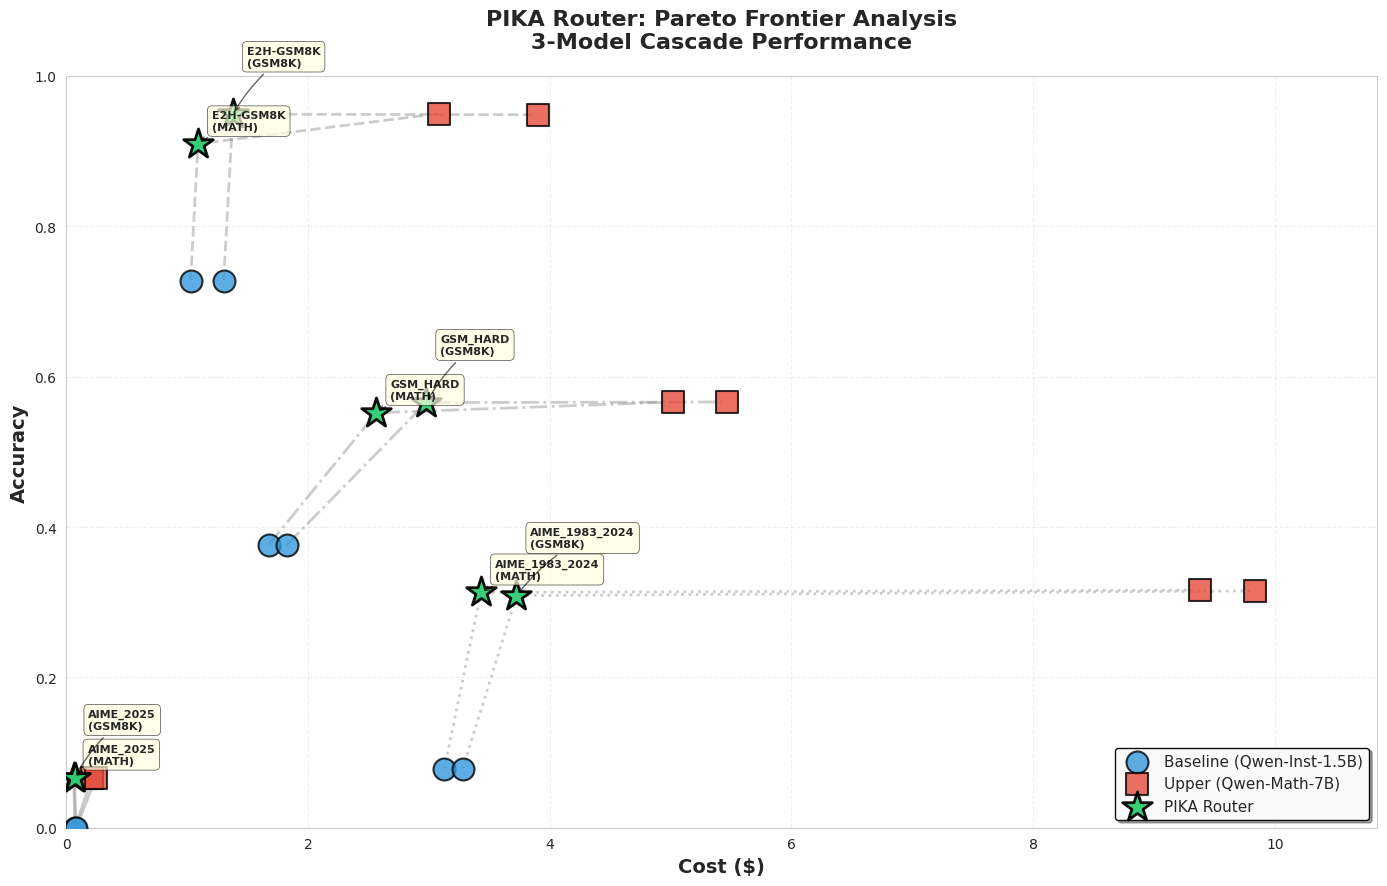


📈 PARETO FRONTIER INTERPRETATION

✨ What we're looking for:
  • Router (green star) close to upper bound (red square) in accuracy
  • Router cost closer to baseline/middle (blue/orange) than upper (red)
  • This indicates efficient routing - high accuracy without burning money

⚠️  Warning signs:
  • Router cost near upper cost = we're routing most questions to expensive model
  • Router accuracy below middle = routing is hurting performance
  • Router below the baseline→upper line = we're off the efficiency frontier


In [31]:
if df is not None:
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # Collect all points for legend management
    plotted_labels = set()
    
    # Plot each dataset
    for dataset_idx, dataset in enumerate(df['dataset'].unique()):
        df_subset = df[df['dataset'] == dataset]
        
        # Use different line styles for different datasets
        line_style = ['-', '--', '-.', ':'][dataset_idx % 4]
        alpha_line = 0.4
        
        for probe_idx, (idx, row) in enumerate(df_subset.iterrows()):
            probe = row['probe_source']
            
            # Calculate costs (use actual if available, otherwise estimate)
            if has_model_costs:
                baseline_cost = row.get('baseline_cost', row['total_cost'] / row['token_multiplier'])
                middle_cost = row.get('middle_cost', baseline_cost * 1.5) if has_middle_model else None
                upper_cost = row.get('upper_cost', baseline_cost * 3.0)
            else:
                # Estimate from token multiplier
                baseline_cost = row['total_cost'] / row['token_multiplier'] if row['token_multiplier'] > 0 else row['total_cost']
                middle_cost = baseline_cost * 1.5 if has_middle_model else None
                upper_cost = baseline_cost * 3.0
            
            middle_acc = row.get('middle_acc', (row['baseline_acc'] + row['upper_acc']) / 2) if has_middle_model else None
            
            # Determine marker offset for multiple probes on same dataset
            offset = probe_idx * 0.00001  # Tiny offset to prevent exact overlap
            
            # Plot baseline (Qwen-Inst-1.5B)
            label_base = 'Baseline (Qwen-Inst-1.5B)' if 'baseline' not in plotted_labels else ""
            if label_base:
                plotted_labels.add('baseline')
            ax.scatter(baseline_cost + offset, row['baseline_acc'], 
                      marker='o', s=250, alpha=0.8, 
                      label=label_base, color=COLORS['baseline'], 
                      edgecolors='black', linewidths=1.5, zorder=3)
            
            # Plot middle model if we have 3-model cascade
            if has_middle_model and middle_cost is not None and middle_acc is not None:
                label_mid = 'Middle (Qwen-Math-1.5B)' if 'middle' not in plotted_labels else ""
                if label_mid:
                    plotted_labels.add('middle')
                ax.scatter(middle_cost + offset, middle_acc, 
                          marker='D', s=250, alpha=0.8,
                          label=label_mid, color=COLORS['middle'],
                          edgecolors='black', linewidths=1.5, zorder=3)
            
            # Plot upper bound (Qwen-Math-7B)
            label_upper = 'Upper (Qwen-Math-7B)' if 'upper' not in plotted_labels else ""
            if label_upper:
                plotted_labels.add('upper')
            ax.scatter(upper_cost + offset, row['upper_acc'], 
                      marker='s', s=250, alpha=0.8,
                      label=label_upper, color=COLORS['upper'],
                      edgecolors='black', linewidths=1.5, zorder=3)
            
            # Plot PIKA Router
            label_router = 'PIKA Router' if 'router' not in plotted_labels else ""
            if label_router:
                plotted_labels.add('router')
            ax.scatter(row['total_cost'] + offset, row['router_acc'], 
                      marker='*', s=500, alpha=0.95,
                      label=label_router, color=COLORS['router'], 
                      edgecolors='black', linewidths=2, zorder=5)
            
            # Connect points to show cascade path
            if has_middle_model and middle_cost is not None and middle_acc is not None:
                costs = [baseline_cost, middle_cost, upper_cost, row['total_cost']]
                accs = [row['baseline_acc'], middle_acc, row['upper_acc'], row['router_acc']]
                # Sort by cost for proper line drawing
                sorted_pairs = sorted(zip(costs, accs), key=lambda x: x[0])
                sorted_costs, sorted_accs = zip(*sorted_pairs)
                ax.plot(sorted_costs, sorted_accs, 
                       color='gray', linestyle=line_style, alpha=alpha_line, linewidth=2, zorder=1)
            else:
                costs = [baseline_cost, upper_cost, row['total_cost']]
                accs = [row['baseline_acc'], row['upper_acc'], row['router_acc']]
                sorted_pairs = sorted(zip(costs, accs), key=lambda x: x[0])
                sorted_costs, sorted_accs = zip(*sorted_pairs)
                ax.plot(sorted_costs, sorted_accs,
                       color='gray', linestyle=line_style, alpha=alpha_line, linewidth=2, zorder=1)
            
            # Annotate dataset + probe
            label_text = f"{dataset}\n({probe})"
            if has_sc_info and row.get('used_sc', False):
                label_text += f"\nSC×{int(row.get('sc_num_samples', 1))}"
            
            ax.annotate(label_text, 
                       (row['total_cost'], row['router_acc']),
                       xytext=(10, 10 + probe_idx * 25), textcoords='offset points',
                       fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', 
                                alpha=0.7, edgecolor='black', linewidth=0.5),
                       ha='left',
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', 
                                      color='black', lw=1, alpha=0.6),
                       zorder=6)
    
    # Formatting
    ax.set_xlabel('Cost ($)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_title('PIKA Router: Pareto Frontier Analysis\n3-Model Cascade Performance', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Legend with clear positioning
    ax.legend(loc='lower right', framealpha=0.95, fontsize=11, 
             edgecolor='black', fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add some padding
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.set_xlim(left=max(0, x_min * 0.95), right=x_max * 1.05)
    ax.set_ylim(bottom=max(0, y_min * 0.95), top=min(1.0, y_max * 1.1))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("📈 PARETO FRONTIER INTERPRETATION")
    print("="*80)
    print("\n✨ What we're looking for:")
    print("  • Router (green star) close to upper bound (red square) in accuracy")
    print("  • Router cost closer to baseline/middle (blue/orange) than upper (red)")
    print("  • This indicates efficient routing - high accuracy without burning money")
    print("\n⚠️  Warning signs:")
    print("  • Router cost near upper cost = we're routing most questions to expensive model")
    print("  • Router accuracy below middle = routing is hurting performance")
    print("  • Router below the baseline→upper line = we're off the efficiency frontier")
    print("="*80)

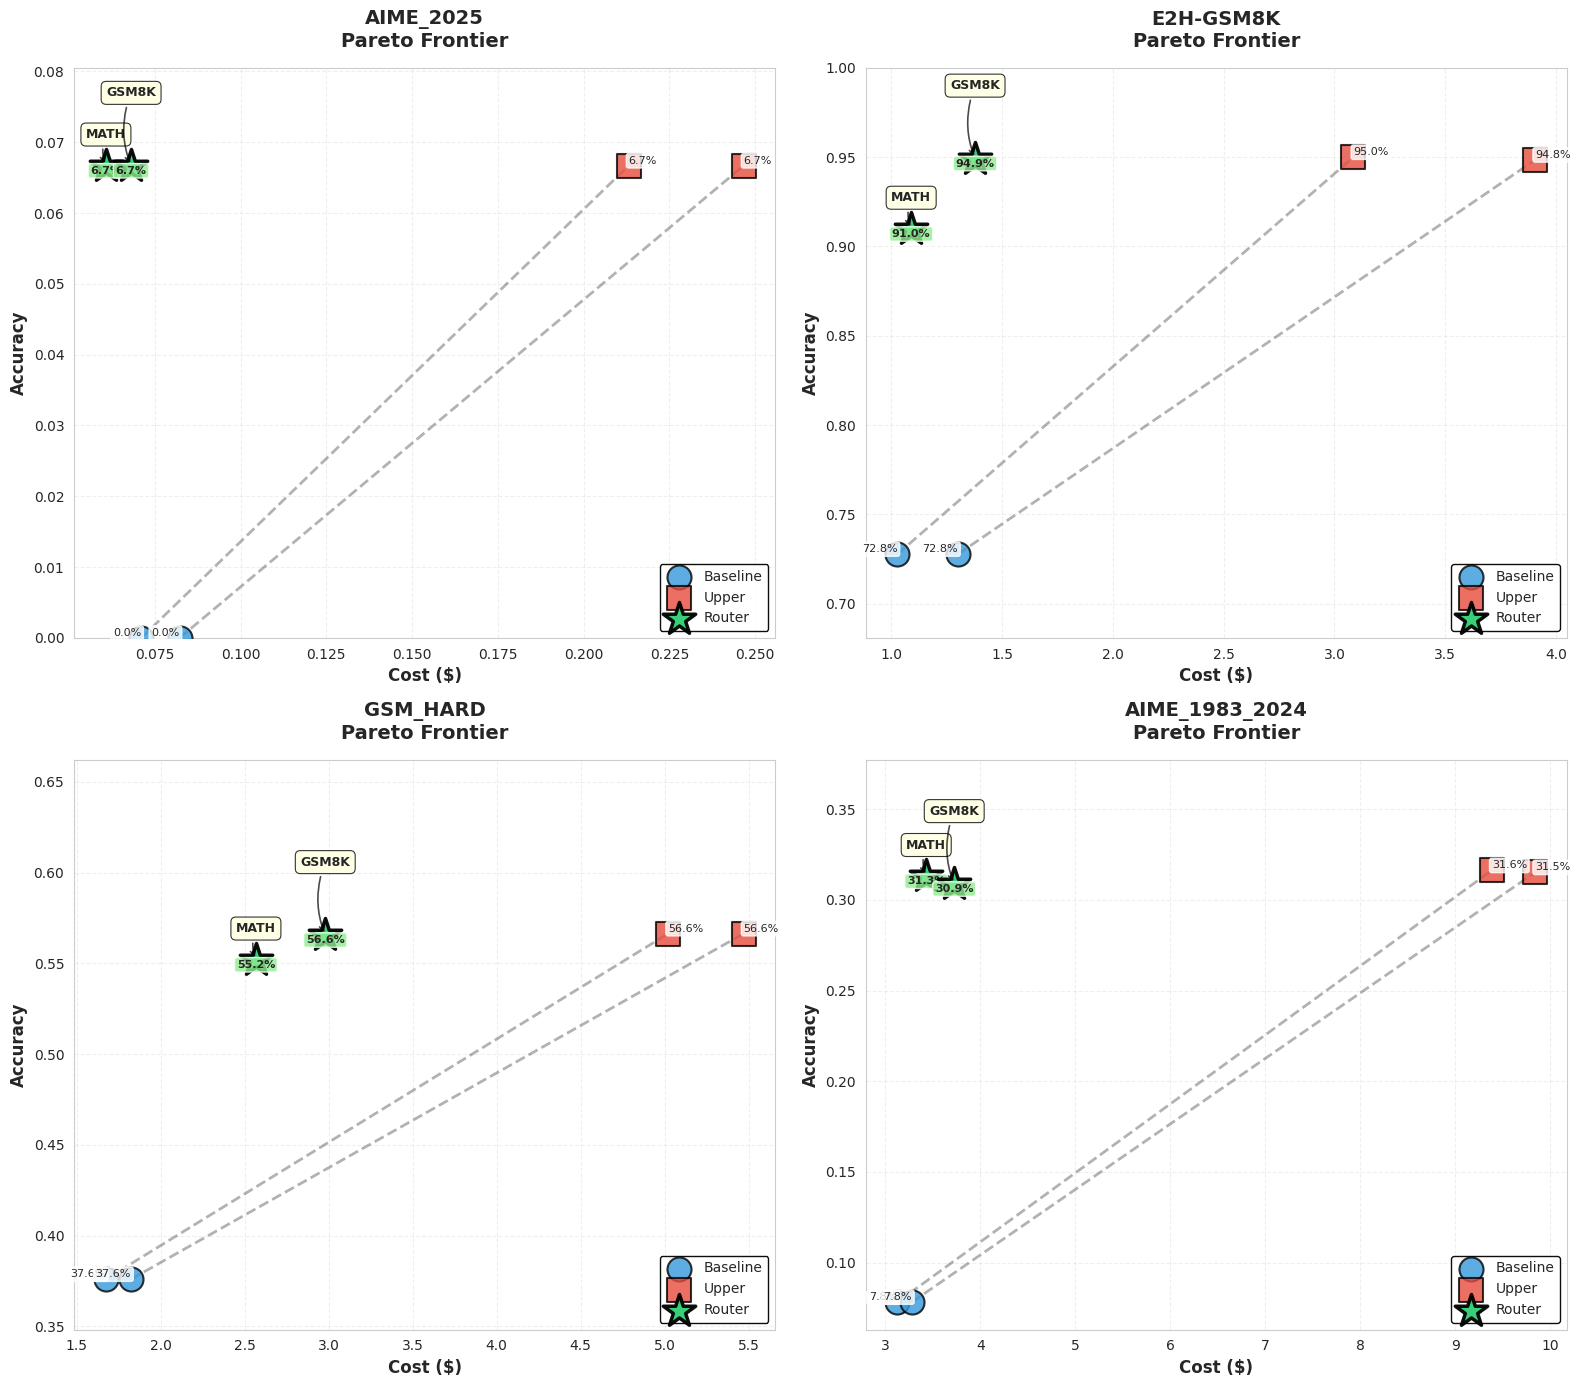

In [32]:
if df is not None:
    datasets = df['dataset'].unique()
    n_datasets = len(datasets)
    
    # Create subplots - 2 columns
    n_cols = 2
    n_rows = (n_datasets + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 7*n_rows))
    if n_datasets == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        df_subset = df[df['dataset'] == dataset]
        
        plotted_labels_local = set()
        
        for probe_idx, (row_idx, row) in enumerate(df_subset.iterrows()):
            probe = row['probe_source']
            
            # Calculate costs
            if has_model_costs:
                baseline_cost = row.get('baseline_cost', row['total_cost'] / row['token_multiplier'])
                middle_cost = row.get('middle_cost', baseline_cost * 1.5) if has_middle_model else None
                upper_cost = row.get('upper_cost', baseline_cost * 3.0)
            else:
                baseline_cost = row['total_cost'] / row['token_multiplier'] if row['token_multiplier'] > 0 else row['total_cost']
                middle_cost = baseline_cost * 1.5 if has_middle_model else None
                upper_cost = baseline_cost * 3.0
            
            middle_acc = row.get('middle_acc', None) if has_middle_model else None
            
            offset = probe_idx * 0.00001
            
            # Plot all models
            label_base = 'Baseline' if 'baseline' not in plotted_labels_local else ""
            if label_base: plotted_labels_local.add('baseline')
            ax.scatter(baseline_cost + offset, row['baseline_acc'], 
                      marker='o', s=300, alpha=0.8, 
                      label=label_base, color=COLORS['baseline'], 
                      edgecolors='black', linewidths=1.5, zorder=3)
            
            if has_middle_model and middle_cost is not None and middle_acc is not None:
                label_mid = 'Middle' if 'middle' not in plotted_labels_local else ""
                if label_mid: plotted_labels_local.add('middle')
                ax.scatter(middle_cost + offset, middle_acc, 
                          marker='D', s=300, alpha=0.8,
                          label=label_mid, color=COLORS['middle'],
                          edgecolors='black', linewidths=1.5, zorder=3)
            
            label_upper = 'Upper' if 'upper' not in plotted_labels_local else ""
            if label_upper: plotted_labels_local.add('upper')
            ax.scatter(upper_cost + offset, row['upper_acc'], 
                      marker='s', s=300, alpha=0.8,
                      label=label_upper, color=COLORS['upper'],
                      edgecolors='black', linewidths=1.5, zorder=3)
            
            label_router = 'Router' if 'router' not in plotted_labels_local else ""
            if label_router: plotted_labels_local.add('router')
            ax.scatter(row['total_cost'] + offset, row['router_acc'], 
                      marker='*', s=600, alpha=0.95,
                      label=label_router, color=COLORS['router'], 
                      edgecolors='black', linewidths=2.5, zorder=5)
            
            # Connect cascade
            if has_middle_model and middle_cost is not None and middle_acc is not None:
                ax.plot([baseline_cost, middle_cost, upper_cost],
                       [row['baseline_acc'], middle_acc, row['upper_acc']],
                       'k--', alpha=0.3, linewidth=2, zorder=1)
            else:
                ax.plot([baseline_cost, upper_cost],
                       [row['baseline_acc'], row['upper_acc']],
                       'k--', alpha=0.3, linewidth=2, zorder=1)
            
            # Annotate with probe + SC info
            label_text = f"{probe}"
            if has_sc_info and row.get('used_sc', False):
                label_text += f" (SC×{int(row.get('sc_num_samples', 1))})"
            
            ax.annotate(label_text, 
                       (row['total_cost'], row['router_acc']),
                       xytext=(0, 20 + probe_idx * 30), textcoords='offset points',
                       fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', 
                                alpha=0.8, edgecolor='black', linewidth=0.8),
                       ha='center',
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                                      color='black', lw=1.2, alpha=0.7),
                       zorder=6)
            
            # Add accuracy percentages near points
            ax.text(baseline_cost, row['baseline_acc'], 
                   f"{row['baseline_acc']:.1%}",
                   ha='right', va='bottom', fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                   zorder=5)
            
            if has_middle_model and middle_cost is not None and middle_acc is not None:
                ax.text(middle_cost, middle_acc, 
                       f"{middle_acc:.1%}",
                       ha='center', va='bottom', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                       zorder=5)
            
            ax.text(upper_cost, row['upper_acc'], 
                   f"{row['upper_acc']:.1%}",
                   ha='left', va='bottom', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                   zorder=5)
            
            ax.text(row['total_cost'], row['router_acc'], 
                   f"{row['router_acc']:.1%}",
                   ha='center', va='top', fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='lightgreen', alpha=0.8),
                   zorder=5)
        
        # Formatting
        ax.set_xlabel('Cost ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax.set_title(f'{dataset}\nPareto Frontier', 
                    fontsize=14, fontweight='bold', pad=15)
        
        # Legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), 
                 loc='lower right', framealpha=0.95, fontsize=10,
                 edgecolor='black', fancybox=True)
        
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Padding
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(bottom=max(0, y_min * 0.95), top=min(1.0, y_max * 1.15))
    
    # Hide extra subplots
    for idx in range(n_datasets, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [9]:
df

,dataset,probe_source,baseline_acc,upper_acc,router_acc,accuracy_gain,token_multiplier,total_cost,results_dir
0,AIME_2025,MATH,0.000000,0.066667,0.066667,0.066667,0.855186,0.023471,../predicting_learnability/PIKA_ROUTER_EXPERIM...
1,AIME_2025,GSM8K,0.000000,0.066667,0.066667,0.066667,0.828309,0.022698,../predicting_learnability/PIKA_ROUTER_EXPERIM...
2,E2H-GSM8K,MATH,0.727066,0.949962,0.910538,0.183472,1.054940,0.457692,../predicting_learnability/PIKA_ROUTER_EXPERIM...
3,E2H-GSM8K,GSM8K,0.727066,0.948446,0.948446,0.221380,1.054348,0.457152,../predicting_learnability/PIKA_ROUTER_EXPERIM...
4,GSM_HARD,MATH,0.376042,0.566338,0.551933,0.175891,1.536279,0.925011,../predicting_learnability/PIKA_ROUTER_EXPERIM...
5,GSM_HARD,GSM8K,0.376042,0.566338,0.565580,0.189538,1.637774,0.995847,../predicting_learnability/PIKA_ROUTER_EXPERIM...
6,AIME_1983_2024,MATH,0.078242,0.320472,0.305466,0.227224,1.099253,1.207540,../predicting_learnability/PIKA_ROUTER_EXPERIM...
7,AIME_1983_2024,GSM8K,0.078242,0.318328,0.310825,0.232583,1.128231,1.241281,../predicting_learnability/PIKA_ROUTER_EXPERIM...


## 2. Routing Distribution: Where Are Questions Being Sent?

Understanding the router's decisions: which models handle which fraction of questions?
This shows if the router is actually making intelligent decisions or just routing everything to one model.

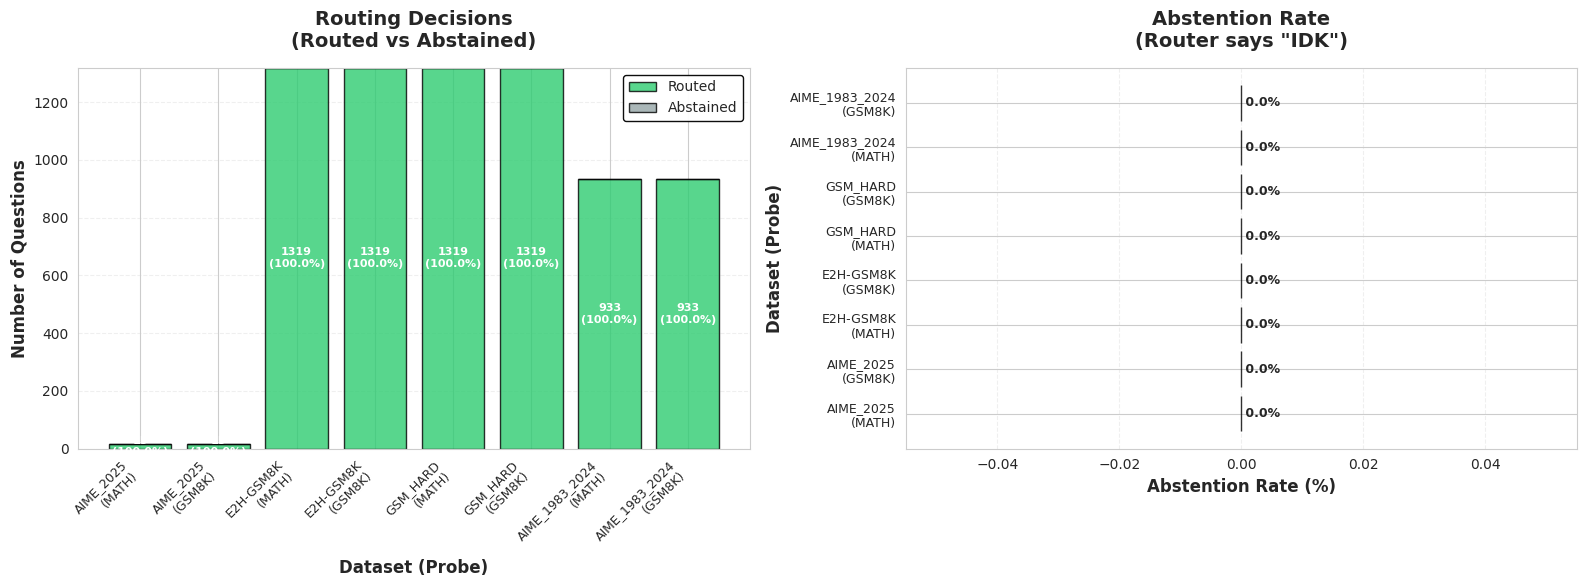


📊 ROUTING STATISTICS

Average abstention rate: 0.0%
Highest abstention: AIME_2025 (0.0%)
Lowest abstention: AIME_2025 (0.0%)


In [33]:
if df is not None:
    # Try to load detailed routing stats from individual result files
    routing_breakdown = []
    
    for idx, row in df.iterrows():
        result_dir = Path(row['results_dir'])
        csv_files = list(result_dir.glob("PIKA_router_results*.csv"))
        
        if csv_files:
            results_df = pd.read_csv(csv_files[0])
            
            # Try to infer routing from cost_multiplier or num_samples patterns
            # This is approximate - ideally we'd save model assignments in the CSV
            total = len(results_df)
            abstained = (results_df['num_samples'] == 0).sum() if 'num_samples' in results_df.columns else 0
            routed = total - abstained
            
            routing_breakdown.append({
                'dataset': row['dataset'],
                'probe': row['probe_source'],
                'total': total,
                'routed': routed,
                'abstained': abstained,
                'abstain_pct': (abstained / total * 100) if total > 0 else 0
            })
    
    if routing_breakdown:
        routing_df = pd.DataFrame(routing_breakdown)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Stacked bar showing routing vs abstain
        datasets_labels = [f"{r['dataset']}\n({r['probe']})" for _, r in routing_df.iterrows()]
        x = np.arange(len(routing_df))
        
        bars1 = axes[0].bar(x, routing_df['routed'], label='Routed', 
                           color=COLORS['router'], alpha=0.8, edgecolor='black', linewidth=1)
        bars2 = axes[0].bar(x, routing_df['abstained'], bottom=routing_df['routed'],
                           label='Abstained', color=COLORS['abstain'], alpha=0.8,
                           edgecolor='black', linewidth=1)
        
        axes[0].set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Dataset (Probe)', fontsize=12, fontweight='bold')
        axes[0].set_title('Routing Decisions\n(Routed vs Abstained)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(datasets_labels, rotation=45, ha='right', fontsize=9)
        axes[0].legend(loc='upper right', framealpha=0.95, edgecolor='black')
        axes[0].grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add percentage labels
        for i, row in routing_df.iterrows():
            if row['routed'] > 0:
                axes[0].text(i, row['routed']/2, f"{row['routed']}\n({row['routed']/row['total']*100:.1f}%)",
                           ha='center', va='center', fontsize=8, fontweight='bold', color='white')
            if row['abstained'] > 0:
                axes[0].text(i, row['routed'] + row['abstained']/2, 
                           f"{row['abstained']}\n({row['abstain_pct']:.1f}%)",
                           ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        
        # Right: Abstention rate
        colors_abstain = [COLORS['abstain'] if x > 5 else COLORS['router'] for x in routing_df['abstain_pct']]
        bars = axes[1].barh(x, routing_df['abstain_pct'], color=colors_abstain, alpha=0.8,
                           edgecolor='black', linewidth=1)
        
        axes[1].set_xlabel('Abstention Rate (%)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Dataset (Probe)', fontsize=12, fontweight='bold')
        axes[1].set_title('Abstention Rate\n(Router says "IDK")', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[1].set_yticks(x)
        axes[1].set_yticklabels(datasets_labels, fontsize=9)
        axes[1].grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, routing_df['abstain_pct'])):
            axes[1].text(val, i, f' {val:.1f}%', 
                        va='center', ha='left', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*80)
        print("📊 ROUTING STATISTICS")
        print("="*80)
        print(f"\nAverage abstention rate: {routing_df['abstain_pct'].mean():.1f}%")
        print(f"Highest abstention: {routing_df.loc[routing_df['abstain_pct'].idxmax(), 'dataset']} "
              f"({routing_df['abstain_pct'].max():.1f}%)")
        print(f"Lowest abstention: {routing_df.loc[routing_df['abstain_pct'].idxmin(), 'dataset']} "
              f"({routing_df['abstain_pct'].min():.1f}%)")
        print("="*80)
    else:
        print("⚠️  Could not load detailed routing statistics from result files.")


## 3. Accuracy vs Cost Trade-off Analysis

How much accuracy gain are we getting for the additional cost? This shows the efficiency of the routing strategy.

/tmp/ipykernel_2670758/2122752523.py:129: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2670758/2122752523.py:129: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/IPython/core/pyla

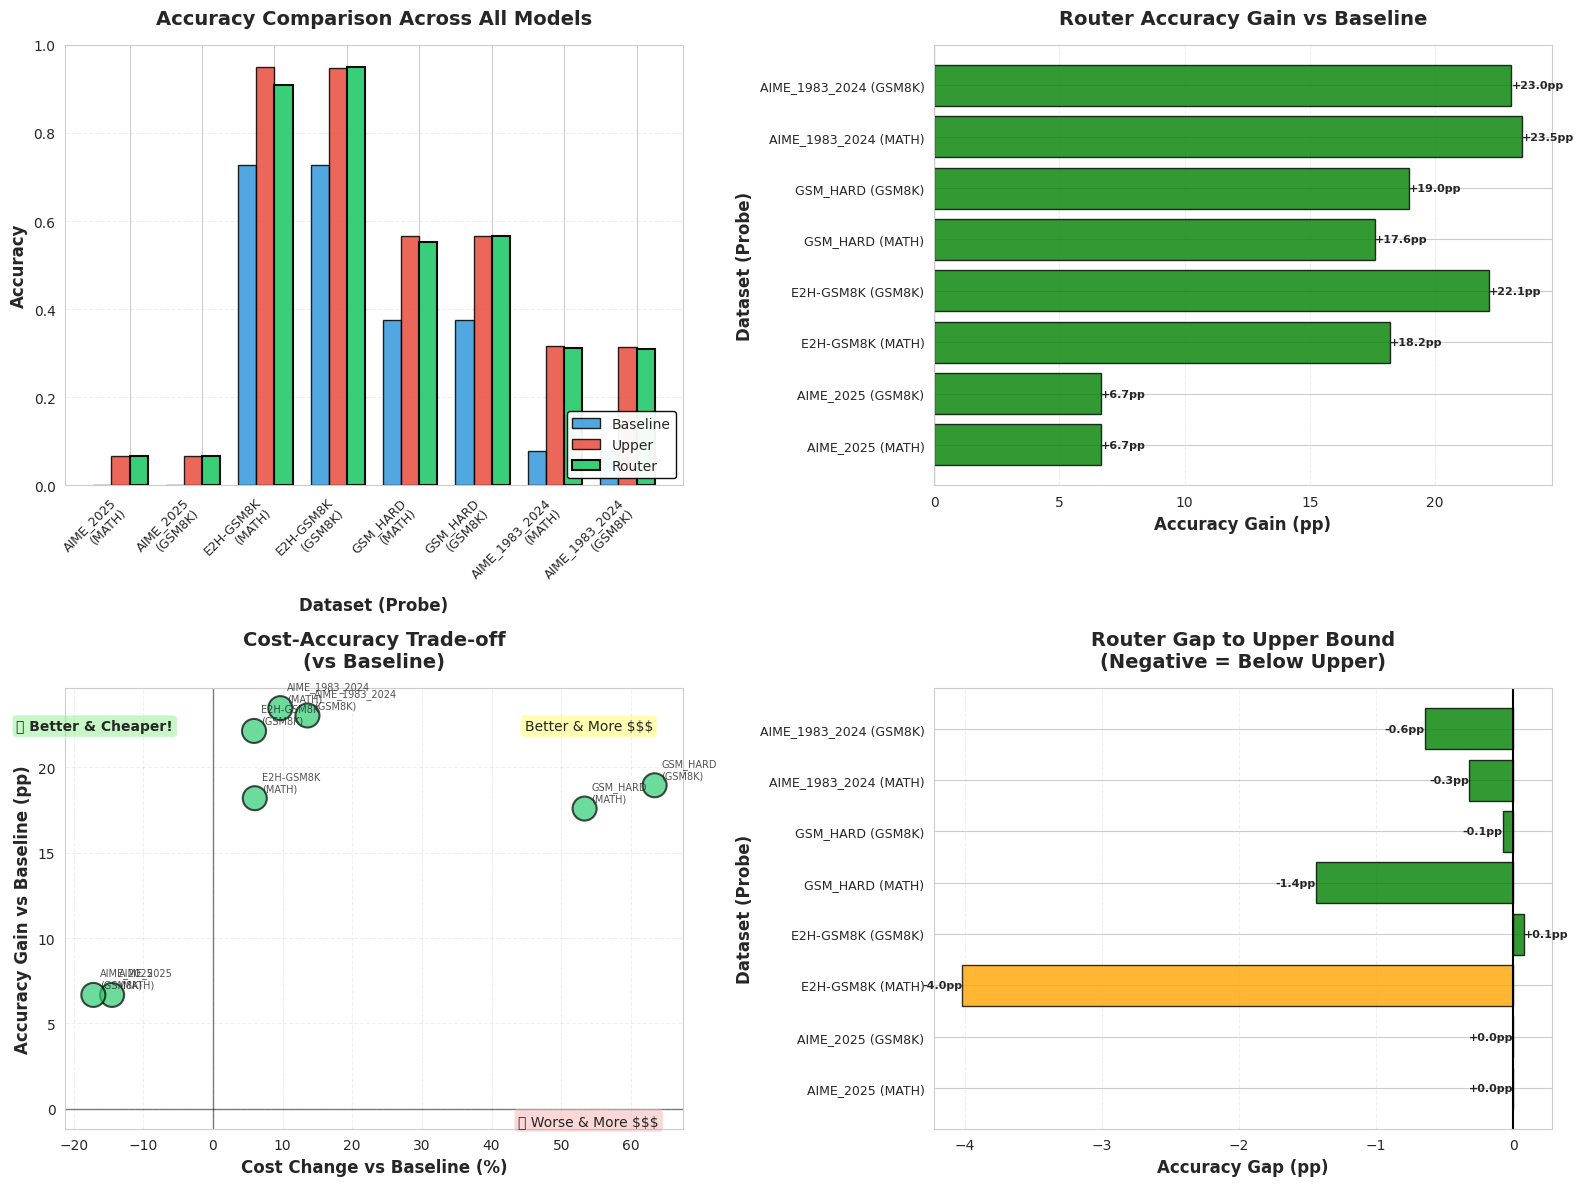


🎯 ACCURACY ANALYSIS

Best router gain vs baseline: AIME_1983_2024 (+23.5pp)
Worst router vs baseline: AIME_2025 (+6.7pp)
Average gain vs baseline: +17.1pp

Smallest gap to upper: AIME_2025 (-4.0pp)
Largest gap to upper: E2H-GSM8K (-4.0pp)
Average gap to upper: -0.8pp


In [34]:
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Prepare data
    df['router_vs_baseline_pp'] = (df['router_acc'] - df['baseline_acc']) * 100
    df['router_vs_upper_pp'] = (df['router_acc'] - df['upper_acc']) * 100
    if has_middle_model and 'middle_acc' in df.columns:
        df['router_vs_middle_pp'] = (df['router_acc'] - df.get('middle_acc', df['baseline_acc'])) * 100
    
    # Calculate cost increases
    if has_model_costs:
        df['cost_vs_baseline_pct'] = ((df['total_cost'] - df.get('baseline_cost', 0)) / df.get('baseline_cost', 1) * 100)
        df['cost_vs_upper_pct'] = ((df['total_cost'] - df.get('upper_cost', 1)) / df.get('upper_cost', 1) * 100)
        if has_middle_model:
            df['cost_vs_middle_pct'] = ((df['total_cost'] - df.get('middle_cost', 1)) / df.get('middle_cost', 1) * 100)
    else:
        # Estimate from token multiplier
        baseline_costs = df['total_cost'] / df['token_multiplier']
        df['cost_vs_baseline_pct'] = ((df['total_cost'] - baseline_costs) / baseline_costs * 100)
        upper_costs = baseline_costs * 3.0
        df['cost_vs_upper_pct'] = ((df['total_cost'] - upper_costs) / upper_costs * 100)
    
    # 1. Accuracy comparison bars (All 3 models + Router)
    x = np.arange(len(df))
    width = 0.2 if has_middle_model else 0.25
    
    bars1 = axes[0].bar(x - 1.5*width, df['baseline_acc'], width, 
                       label='Baseline', alpha=0.85, color=COLORS['baseline'],
                       edgecolor='black', linewidth=1)
    
    if has_middle_model and 'middle_acc' in df.columns:
        bars2 = axes[0].bar(x - 0.5*width, df['middle_acc'], width,
                           label='Middle', alpha=0.85, color=COLORS['middle'],
                           edgecolor='black', linewidth=1)
        bars3 = axes[0].bar(x + 0.5*width, df['upper_acc'], width,
                           label='Upper', alpha=0.85, color=COLORS['upper'],
                           edgecolor='black', linewidth=1)
        bars4 = axes[0].bar(x + 1.5*width, df['router_acc'], width,
                           label='Router', alpha=0.95, color=COLORS['router'],
                           edgecolor='black', linewidth=1.5)
    else:
        bars2 = axes[0].bar(x - 0.5*width, df['upper_acc'], width,
                           label='Upper', alpha=0.85, color=COLORS['upper'],
                           edgecolor='black', linewidth=1)
        bars3 = axes[0].bar(x + 0.5*width, df['router_acc'], width,
                           label='Router', alpha=0.95, color=COLORS['router'],
                           edgecolor='black', linewidth=1.5)
    
    axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Dataset (Probe)', fontsize=12, fontweight='bold')
    axes[0].set_title('Accuracy Comparison Across All Models', fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f"{d}\n({p})" for d, p in zip(df['dataset'], df['probe_source'])], 
                           rotation=45, ha='right', fontsize=9)
    axes[0].legend(loc='lower right', framealpha=0.95, edgecolor='black')
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[0].set_ylim([0, 1.0])
    
    # 2. Accuracy gain from baseline (percentage points)
    colors_gain = ['green' if x > 0 else 'red' for x in df['router_vs_baseline_pp']]
    bars = axes[1].barh(range(len(df)), df['router_vs_baseline_pp'], 
                       color=colors_gain, alpha=0.8, edgecolor='black', linewidth=1)
    
    axes[1].set_xlabel('Accuracy Gain (pp)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Dataset (Probe)', fontsize=12, fontweight='bold')
    axes[1].set_title('Router Accuracy Gain vs Baseline', fontsize=14, fontweight='bold', pad=15)
    axes[1].set_yticks(range(len(df)))
    axes[1].set_yticklabels([f"{d} ({p})" for d, p in zip(df['dataset'], df['probe_source'])], fontsize=9)
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, val) in enumerate(zip(bars, df['router_vs_baseline_pp'])):
        axes[1].text(val, i, f'{val:+.1f}pp', 
                    va='center', ha='left' if val > 0 else 'right',
                    fontsize=8, fontweight='bold')
    
    # 3. Cost efficiency (cost increase vs accuracy gain)
    scatter_colors = [COLORS['router'] if g > 0 else COLORS['abstain'] for g in df['router_vs_baseline_pp']]
    axes[2].scatter(df['cost_vs_baseline_pct'], df['router_vs_baseline_pp'], 
                   s=300, alpha=0.7, c=scatter_colors, edgecolors='black', linewidths=1.5)
    
    # Add quadrant lines
    axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[2].axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Add quadrant labels
    axes[2].text(axes[2].get_xlim()[1] * 0.8, axes[2].get_ylim()[1] * 0.9,
                'Better & More $$$', ha='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    axes[2].text(axes[2].get_xlim()[0] * 0.8, axes[2].get_ylim()[1] * 0.9,
                '🎯 Better & Cheaper!', ha='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    axes[2].text(axes[2].get_xlim()[1] * 0.8, axes[2].get_ylim()[0] * 0.8,
                '❌ Worse & More $$$', ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    
    axes[2].set_xlabel('Cost Change vs Baseline (%)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Accuracy Gain vs Baseline (pp)', fontsize=12, fontweight='bold')
    axes[2].set_title('Cost-Accuracy Trade-off\n(vs Baseline)', fontsize=14, fontweight='bold', pad=15)
    axes[2].grid(True, alpha=0.3, linestyle='--')
    
    # Annotate points
    for idx, row in df.iterrows():
        axes[2].annotate(f"{row['dataset']}\n({row['probe_source']})", 
                        (row['cost_vs_baseline_pct'], row['router_vs_baseline_pp']),
                        xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)
    
    # 4. Gap to upper bound
    colors_gap = ['green' if abs(x) < 2 else 'orange' if abs(x) < 5 else 'red' 
                  for x in df['router_vs_upper_pp']]
    bars = axes[3].barh(range(len(df)), df['router_vs_upper_pp'], 
                       color=colors_gap, alpha=0.8, edgecolor='black', linewidth=1)
    
    axes[3].set_xlabel('Accuracy Gap (pp)', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Dataset (Probe)', fontsize=12, fontweight='bold')
    axes[3].set_title('Router Gap to Upper Bound\n(Negative = Below Upper)', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[3].set_yticks(range(len(df)))
    axes[3].set_yticklabels([f"{d} ({p})" for d, p in zip(df['dataset'], df['probe_source'])], fontsize=9)
    axes[3].axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    axes[3].grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, val) in enumerate(zip(bars, df['router_vs_upper_pp'])):
        axes[3].text(val, i, f'{val:+.1f}pp', 
                    va='center', ha='left' if val > 0 else 'right',
                    fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("🎯 ACCURACY ANALYSIS")
    print("="*80)
    print(f"\nBest router gain vs baseline: {df.loc[df['router_vs_baseline_pp'].idxmax(), 'dataset']} "
          f"({df['router_vs_baseline_pp'].max():+.1f}pp)")
    print(f"Worst router vs baseline: {df.loc[df['router_vs_baseline_pp'].idxmin(), 'dataset']} "
          f"({df['router_vs_baseline_pp'].min():+.1f}pp)")
    print(f"Average gain vs baseline: {df['router_vs_baseline_pp'].mean():+.1f}pp")
    print(f"\nSmallest gap to upper: {df.loc[df['router_vs_upper_pp'].abs().idxmin(), 'dataset']} "
          f"({df['router_vs_upper_pp'].min():+.1f}pp)")
    print(f"Largest gap to upper: {df.loc[df['router_vs_upper_pp'].abs().idxmax(), 'dataset']} "
          f"({df['router_vs_upper_pp'].min():+.1f}pp)")
    print(f"Average gap to upper: {df['router_vs_upper_pp'].mean():+.1f}pp")
    print("="*80)

## 4. Cost Efficiency & ROI Analysis

Token multiplier and return on investment - are we being smart with compute?

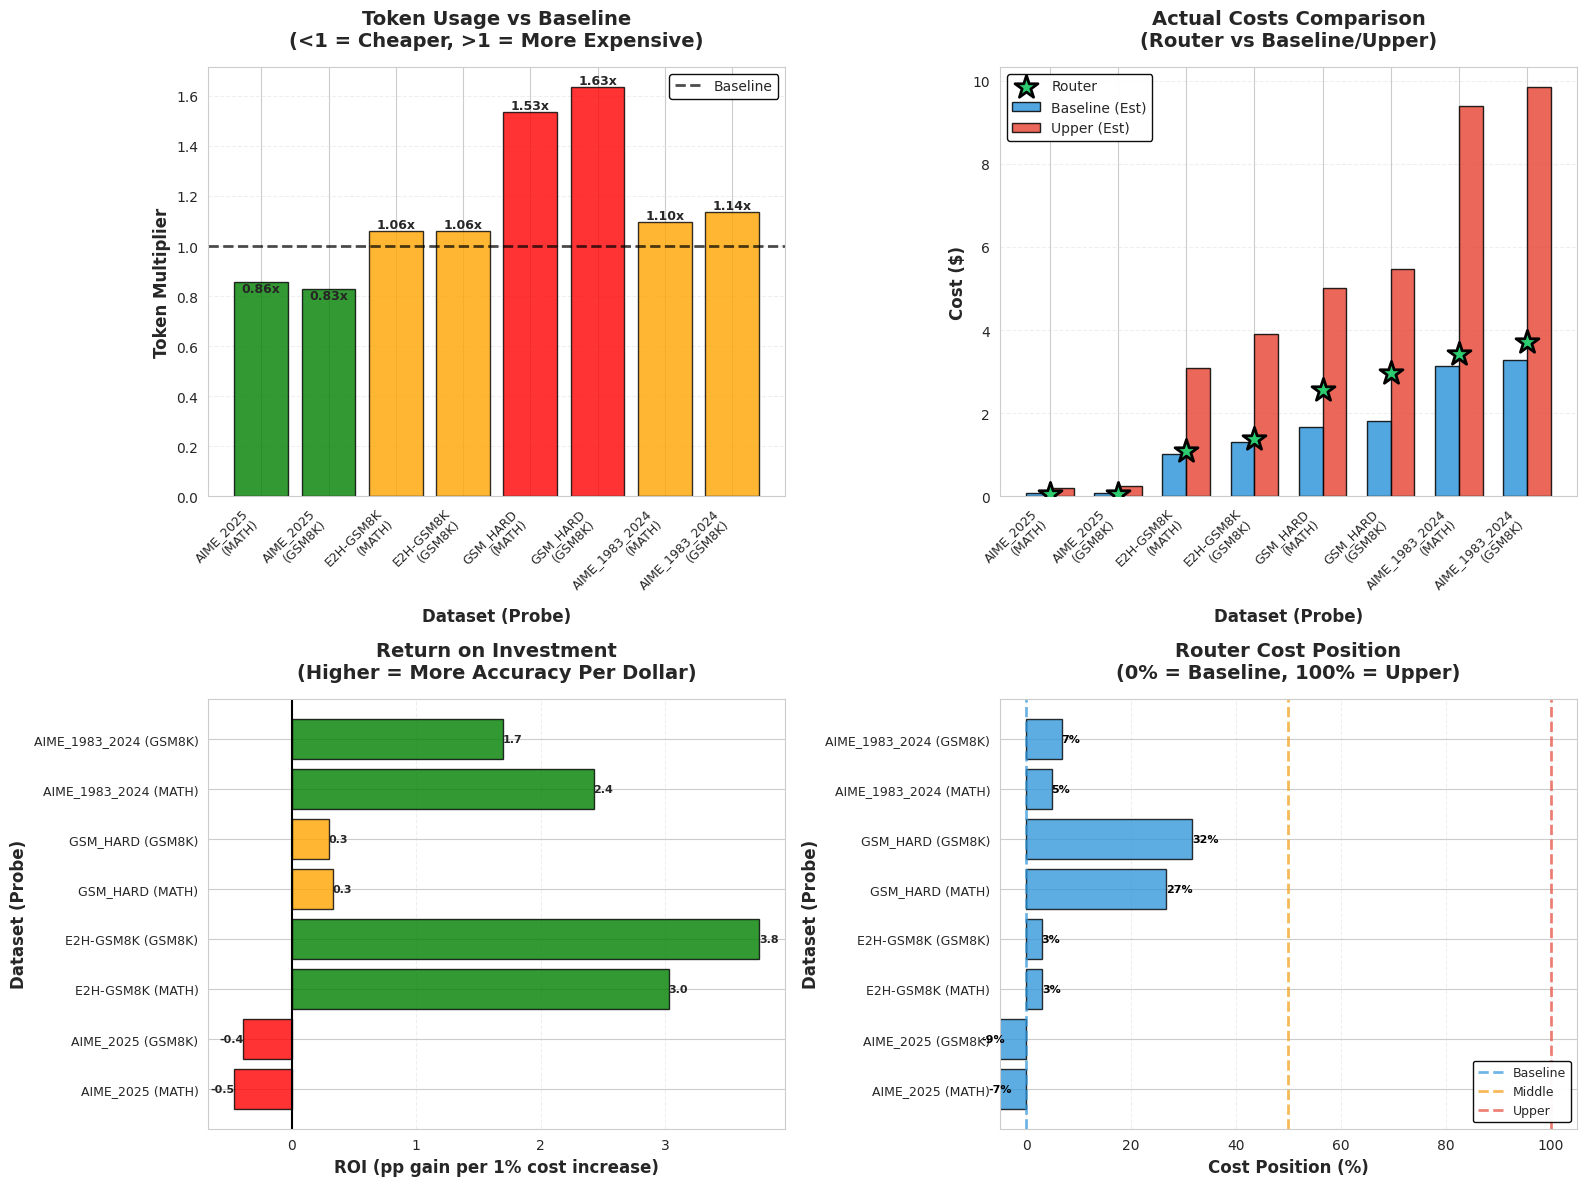


💰 COST EFFICIENCY ANALYSIS

Token multiplier range: 0.83x - 1.63x
Average token multiplier: 1.15x
Configurations with token SAVINGS: 2/8

Average ROI: 1.34 pp per 1% cost increase
Best ROI: E2H-GSM8K (3.75)

Average cost position: 8%
  (0% = baseline cost, 50% = middle, 100% = upper cost)


In [35]:
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # 1. Token multiplier comparison
    x = np.arange(len(df))
    colors_token = ['green' if x < 1 else 'orange' if x < 1.5 else 'red' 
                    for x in df['token_multiplier']]
    bars = axes[0].bar(x, df['token_multiplier'], color=colors_token, alpha=0.8,
                      edgecolor='black', linewidth=1)
    
    axes[0].set_ylabel('Token Multiplier', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Dataset (Probe)', fontsize=12, fontweight='bold')
    axes[0].set_title('Token Usage vs Baseline\n(<1 = Cheaper, >1 = More Expensive)', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f"{d}\n({p})" for d, p in zip(df['dataset'], df['probe_source'])], 
                           rotation=45, ha='right', fontsize=9)
    axes[0].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Baseline', alpha=0.7)
    axes[0].legend(loc='upper right', framealpha=0.95, edgecolor='black')
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    
    for i, (bar, val) in enumerate(zip(bars, df['token_multiplier'])):
        axes[0].text(i, val, f'{val:.2f}x', 
                    ha='center', va='bottom' if val > 1 else 'top',
                    fontsize=9, fontweight='bold')
    
    # 2. Cost comparison (actual $$$)
    if has_model_costs:
        baseline_costs = df.get('baseline_cost', df['total_cost'] / df['token_multiplier'])
        upper_costs = df.get('upper_cost', baseline_costs * 3)
        
        width = 0.25
        bars1 = axes[1].bar(x - width, baseline_costs, width, 
                           label='Baseline Cost', alpha=0.85, color=COLORS['baseline'],
                           edgecolor='black', linewidth=1)
        
        if has_middle_model and 'middle_cost' in df.columns:
            bars2 = axes[1].bar(x, df['middle_cost'], width,
                               label='Middle Cost', alpha=0.85, color=COLORS['middle'],
                               edgecolor='black', linewidth=1)
            bars3 = axes[1].bar(x + width, upper_costs, width,
                               label='Upper Cost', alpha=0.85, color=COLORS['upper'],
                               edgecolor='black', linewidth=1)
        else:
            bars2 = axes[1].bar(x, upper_costs, width,
                               label='Upper Cost', alpha=0.85, color=COLORS['upper'],
                               edgecolor='black', linewidth=1)
        
        # Router cost as scatter points
        axes[1].scatter(x, df['total_cost'], s=300, marker='*', 
                       label='Router Cost', color=COLORS['router'], 
                       edgecolors='black', linewidths=2, zorder=5)
    else:
        baseline_costs = df['total_cost'] / df['token_multiplier']
        upper_costs = baseline_costs * 3
        
        width = 0.35
        bars1 = axes[1].bar(x - width/2, baseline_costs, width,
                           label='Baseline (Est)', alpha=0.85, color=COLORS['baseline'],
                           edgecolor='black', linewidth=1)
        bars2 = axes[1].bar(x + width/2, upper_costs, width,
                           label='Upper (Est)', alpha=0.85, color=COLORS['upper'],
                           edgecolor='black', linewidth=1)
        axes[1].scatter(x, df['total_cost'], s=300, marker='*',
                       label='Router', color=COLORS['router'],
                       edgecolors='black', linewidths=2, zorder=5)
    
    axes[1].set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Dataset (Probe)', fontsize=12, fontweight='bold')
    axes[1].set_title('Actual Costs Comparison\n(Router vs Baseline/Upper)', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f"{d}\n({p})" for d, p in zip(df['dataset'], df['probe_source'])], 
                           rotation=45, ha='right', fontsize=9)
    axes[1].legend(loc='upper left', framealpha=0.95, edgecolor='black', fontsize=10)
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')
    
    # 3. ROI: Accuracy gain per unit cost increase
    df_roi = df.copy()
    if has_model_costs:
        df_roi['cost_increase'] = df['total_cost'] - df.get('baseline_cost', baseline_costs)
        df_roi['roi'] = (df['router_vs_baseline_pp'] / 
                        (df_roi['cost_increase'] / df.get('baseline_cost', baseline_costs) * 100))
    else:
        df_roi['cost_increase'] = df['total_cost'] - baseline_costs
        df_roi['roi'] = (df['router_vs_baseline_pp'] / 
                        (df_roi['cost_increase'] / baseline_costs * 100))
    
    df_roi['roi'] = df_roi['roi'].replace([np.inf, -np.inf], np.nan)
    
    if not df_roi['roi'].isna().all():
        colors_roi = ['green' if x > 0.5 else 'orange' if x > 0 else 'red' 
                     for x in df_roi['roi'].fillna(0)]
        bars_roi = axes[2].barh(range(len(df_roi)), df_roi['roi'].fillna(0), 
                               color=colors_roi, alpha=0.8, edgecolor='black', linewidth=1)
        
        axes[2].set_xlabel('ROI (pp gain per 1% cost increase)', fontsize=12, fontweight='bold')
        axes[2].set_ylabel('Dataset (Probe)', fontsize=12, fontweight='bold')
        axes[2].set_title('Return on Investment\n(Higher = More Accuracy Per Dollar)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[2].set_yticks(range(len(df_roi)))
        axes[2].set_yticklabels([f"{d} ({p})" for d, p in zip(df_roi['dataset'], df_roi['probe_source'])], 
                               fontsize=9)
        axes[2].axvline(x=0, color='black', linestyle='-', linewidth=1.5)
        axes[2].grid(axis='x', alpha=0.3, linestyle='--')
        
        for i, (bar, val) in enumerate(zip(bars_roi, df_roi['roi'].fillna(0))):
            if not np.isnan(val) and val != 0:
                axes[2].text(val, i, f'{val:.1f}', 
                            va='center', ha='left' if val > 0 else 'right',
                            fontsize=8, fontweight='bold')
    
    # 4. Cost position relative to baseline and upper
    if has_model_costs:
        df['cost_position'] = ((df['total_cost'] - df.get('baseline_cost', baseline_costs)) / 
                              (df.get('upper_cost', upper_costs) - df.get('baseline_cost', baseline_costs)) * 100)
    else:
        df['cost_position'] = ((df['total_cost'] - baseline_costs) / 
                              (upper_costs - baseline_costs) * 100)
    
    colors_pos = [COLORS['baseline'] if x < 33 else COLORS['middle'] if x < 67 else COLORS['upper'] 
                  for x in df['cost_position']]
    bars_pos = axes[3].barh(range(len(df)), df['cost_position'], color=colors_pos, alpha=0.8,
                           edgecolor='black', linewidth=1)
    
    axes[3].set_xlabel('Cost Position (%)', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Dataset (Probe)', fontsize=12, fontweight='bold')
    axes[3].set_title('Router Cost Position\n(0% = Baseline, 100% = Upper)', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[3].set_yticks(range(len(df)))
    axes[3].set_yticklabels([f"{d} ({p})" for d, p in zip(df['dataset'], df['probe_source'])], fontsize=9)
    axes[3].axvline(x=0, color=COLORS['baseline'], linestyle='--', linewidth=2, label='Baseline', alpha=0.7)
    axes[3].axvline(x=50, color=COLORS['middle'], linestyle='--', linewidth=2, label='Middle', alpha=0.7)
    axes[3].axvline(x=100, color=COLORS['upper'], linestyle='--', linewidth=2, label='Upper', alpha=0.7)
    axes[3].legend(loc='lower right', framealpha=0.95, edgecolor='black', fontsize=9)
    axes[3].grid(axis='x', alpha=0.3, linestyle='--')
    axes[3].set_xlim([-5, 105])
    
    for i, (bar, val) in enumerate(zip(bars_pos, df['cost_position'])):
        axes[3].text(val, i, f'{val:.0f}%', 
                    va='center', ha='left' if val < 50 else 'right',
                    fontsize=8, fontweight='bold', color='white' if val > 50 else 'black')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("💰 COST EFFICIENCY ANALYSIS")
    print("="*80)
    print(f"\nToken multiplier range: {df['token_multiplier'].min():.2f}x - {df['token_multiplier'].max():.2f}x")
    print(f"Average token multiplier: {df['token_multiplier'].mean():.2f}x")
    
    savings_count = (df['token_multiplier'] < 1).sum()
    if savings_count > 0:
        print(f"Configurations with token SAVINGS: {savings_count}/{len(df)}")
    else:
        print("No configurations with token savings (spending more everywhere)")
    
    if not df_roi['roi'].isna().all():
        print(f"\nAverage ROI: {df_roi['roi'].mean():.2f} pp per 1% cost increase")
        print(f"Best ROI: {df_roi.loc[df_roi['roi'].idxmax(), 'dataset']} ({df_roi['roi'].max():.2f})")
    
    print(f"\nAverage cost position: {df['cost_position'].mean():.0f}%")
    print(f"  (0% = baseline cost, 50% = middle, 100% = upper cost)")
    print("="*80)

## 5. Probe Source Comparison

Which probe (MATH vs GSM8K) provides better routing decisions?

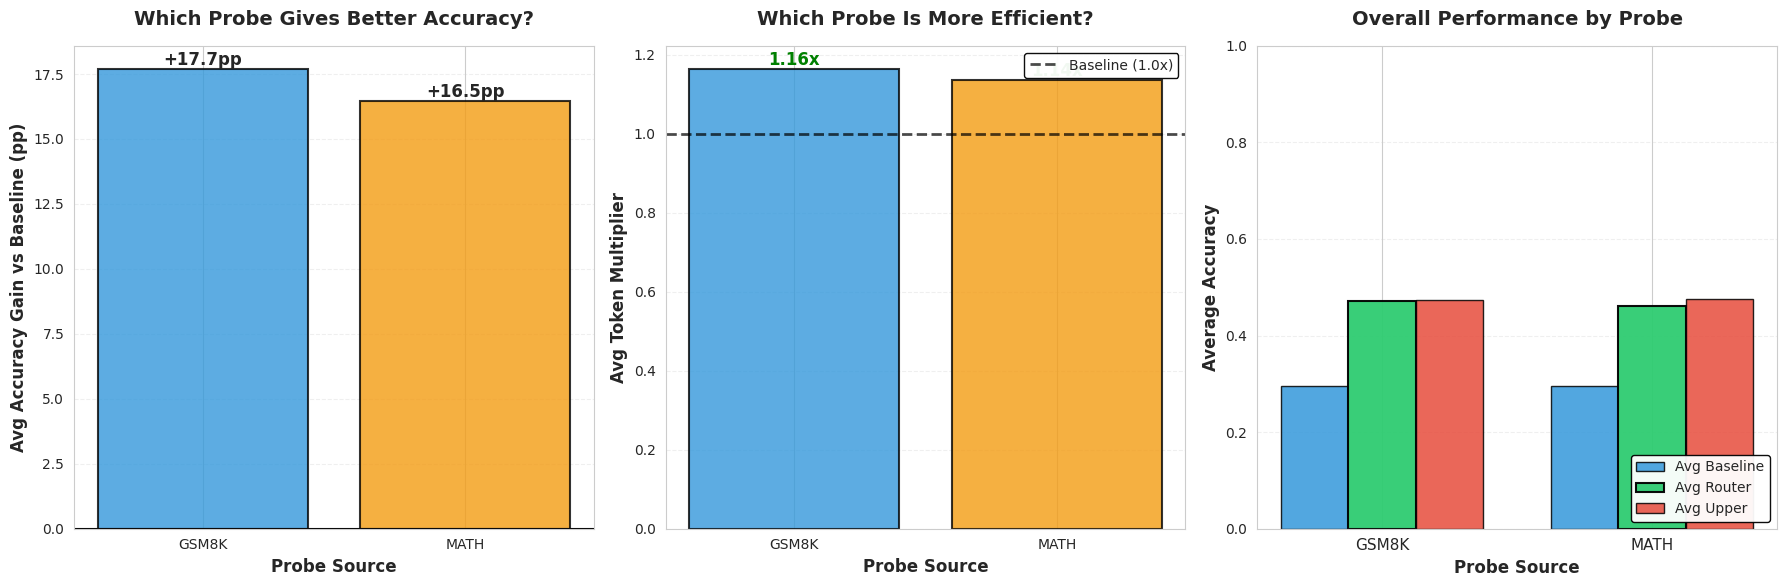


🔍 PROBE SOURCE COMPARISON

GSM8K Probe:
  • Avg accuracy gain vs baseline: +17.7pp
  • Avg token multiplier: 1.16x
  • Avg router accuracy: 47.3%
  • Avg cost: $2.03779

MATH Probe:
  • Avg accuracy gain vs baseline: +16.5pp
  • Avg token multiplier: 1.14x
  • Avg router accuracy: 46.0%
  • Avg cost: $1.78695

🏆 Winner:
  • Best accuracy gains: GSM8K
  • Most token efficient: MATH


In [36]:
if df is not None and 'probe_source' in df.columns and df['probe_source'].nunique() > 1:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    probe_comparison = df.groupby('probe_source').agg({
        'router_vs_baseline_pp': 'mean',
        'token_multiplier': 'mean',
        'router_acc': 'mean',
        'baseline_acc': 'mean',
        'upper_acc': 'mean',
        'total_cost': 'mean'
    }).reset_index()
    
    probe_comparison.columns = ['probe_source', 'avg_gain', 'avg_token_mult', 
                                'avg_router_acc', 'avg_baseline_acc', 'avg_upper_acc', 'avg_cost']
    
    # 1. Average accuracy gain by probe
    probes = probe_comparison['probe_source']
    colors_probes = [COLORS['baseline'], COLORS['middle']][:len(probes)]
    
    bars = axes[0].bar(probes, probe_comparison['avg_gain'],
                      color=colors_probes, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Avg Accuracy Gain vs Baseline (pp)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Probe Source', fontsize=12, fontweight='bold')
    axes[0].set_title('Which Probe Gives Better Accuracy?', fontsize=14, fontweight='bold', pad=15)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:+.1f}pp',
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=12, fontweight='bold')
    
    # 2. Token efficiency by probe
    bars2 = axes[1].bar(probes, probe_comparison['avg_token_mult'],
                       color=colors_probes, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('Avg Token Multiplier', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Probe Source', fontsize=12, fontweight='bold')
    axes[1].set_title('Which Probe Is More Efficient?', fontsize=14, fontweight='bold', pad=15)
    axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
    axes[1].legend(loc='upper right', framealpha=0.95, edgecolor='black')
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar in bars2:
        height = bar.get_height()
        color = 'green' if height < 1.2 else 'orange' if height < 1.5 else 'red'
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}x',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color=color)
    
    # 3. Grouped bar: all accuracy metrics by probe
    x_probe = np.arange(len(probes))
    width = 0.25
    
    bars1 = axes[2].bar(x_probe - width, probe_comparison['avg_baseline_acc'], width,
                       label='Avg Baseline', alpha=0.85, color=COLORS['baseline'],
                       edgecolor='black', linewidth=1)
    bars2 = axes[2].bar(x_probe, probe_comparison['avg_router_acc'], width,
                       label='Avg Router', alpha=0.95, color=COLORS['router'],
                       edgecolor='black', linewidth=1.5)
    bars3 = axes[2].bar(x_probe + width, probe_comparison['avg_upper_acc'], width,
                       label='Avg Upper', alpha=0.85, color=COLORS['upper'],
                       edgecolor='black', linewidth=1)
    
    axes[2].set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Probe Source', fontsize=12, fontweight='bold')
    axes[2].set_title('Overall Performance by Probe', fontsize=14, fontweight='bold', pad=15)
    axes[2].set_xticks(x_probe)
    axes[2].set_xticklabels(probes, fontsize=11)
    axes[2].legend(loc='lower right', framealpha=0.95, edgecolor='black')
    axes[2].grid(axis='y', alpha=0.3, linestyle='--')
    axes[2].set_ylim([0, 1.0])
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("🔍 PROBE SOURCE COMPARISON")
    print("="*80)
    for _, row in probe_comparison.iterrows():
        print(f"\n{row['probe_source']} Probe:")
        print(f"  • Avg accuracy gain vs baseline: {row['avg_gain']:+.1f}pp")
        print(f"  • Avg token multiplier: {row['avg_token_mult']:.2f}x")
        print(f"  • Avg router accuracy: {row['avg_router_acc']:.1%}")
        print(f"  • Avg cost: ${row['avg_cost']:.5f}")
    
    # Determine winner
    best_probe = probe_comparison.loc[probe_comparison['avg_gain'].idxmax(), 'probe_source']
    most_efficient_probe = probe_comparison.loc[probe_comparison['avg_token_mult'].idxmin(), 'probe_source']
    
    print(f"\n🏆 Winner:")
    print(f"  • Best accuracy gains: {best_probe}")
    print(f"  • Most token efficient: {most_efficient_probe}")
    print("="*80)
elif df is not None:
    print("⚠️  Only one probe source found - cannot compare.")

## 6. Executive Summary

The TL;DR of what we learned from this routing experiment.

In [37]:
if df is not None:
    print("="*80)
    print("📊 PIKA ROUTER EXECUTIVE SUMMARY".center(80))
    print("="*80)
    
    print("\n" + "🎯 ACCURACY PERFORMANCE" + " "*57)
    print("-"*80)
    best_acc_idx = df['router_acc'].idxmax()
    worst_acc_idx = df['router_acc'].idxmin()
    print(f"  Best result:  {df.loc[best_acc_idx, 'dataset']:20s} @ {df.loc[best_acc_idx, 'router_acc']:6.1%} "
          f"({df.loc[best_acc_idx, 'probe_source']} probe)")
    print(f"  Worst result: {df.loc[worst_acc_idx, 'dataset']:20s} @ {df.loc[worst_acc_idx, 'router_acc']:6.1%} "
          f"({df.loc[worst_acc_idx, 'probe_source']} probe)")
    print(f"  Average router accuracy: {df['router_acc'].mean():.1%}")
    print(f"  Average gain over baseline: {df['router_vs_baseline_pp'].mean():+.1f}pp")
    positive_gains = (df['router_vs_baseline_pp'] > 0).sum()
    print(f"  Configs with positive gain: {positive_gains}/{len(df)} ({positive_gains/len(df)*100:.0f}%)")
    
    print("\n" + "💰 COST EFFICIENCY" + " "*63)
    print("-"*80)
    print(f"  Average token multiplier: {df['token_multiplier'].mean():.2f}x")
    best_eff_idx = df['token_multiplier'].idxmin()
    worst_eff_idx = df['token_multiplier'].idxmax()
    print(f"  Best efficiency:  {df.loc[best_eff_idx, 'dataset']:20s} @ {df.loc[best_eff_idx, 'token_multiplier']:.2f}x "
          f"({df.loc[best_eff_idx, 'probe_source']} probe)")
    print(f"  Worst efficiency: {df.loc[worst_eff_idx, 'dataset']:20s} @ {df.loc[worst_eff_idx, 'token_multiplier']:.2f}x "
          f"({df.loc[worst_eff_idx, 'probe_source']} probe)")
    
    if has_model_costs:
        print(f"  Average router cost: ${df['total_cost'].mean():.5f}")
        if 'baseline_cost' in df.columns:
            print(f"  Average baseline cost: ${df['baseline_cost'].mean():.5f}")
        if 'upper_cost' in df.columns:
            print(f"  Average upper cost: ${df['upper_cost'].mean():.5f}")
    
    print("\n" + "🏆 GAP TO UPPER BOUND" + " "*58)
    print("-"*80)
    print(f"  Average gap to upper: {df['router_vs_upper_pp'].mean():.1f}pp")
    smallest_gap_idx = df['router_vs_upper_pp'].abs().idxmin()
    largest_gap_idx = df['router_vs_upper_pp'].abs().idxmax()
    print(f"  Smallest gap: {df.loc[smallest_gap_idx, 'dataset']:20s} @ {df.loc[smallest_gap_idx, 'router_vs_upper_pp']:+.1f}pp "
          f"({df.loc[smallest_gap_idx, 'probe_source']} probe)")
    print(f"  Largest gap:  {df.loc[largest_gap_idx, 'dataset']:20s} @ {df.loc[largest_gap_idx, 'router_vs_upper_pp']:+.1f}pp "
          f"({df.loc[largest_gap_idx, 'probe_source']} probe)")
    
    # Gap analysis
    close_to_upper = (df['router_vs_upper_pp'].abs() < 2).sum()
    print(f"  Configs within 2pp of upper: {close_to_upper}/{len(df)} ({close_to_upper/len(df)*100:.0f}%)")
    
    if has_middle_model and 'middle_acc' in df.columns:
        print("\n" + "🎨 3-MODEL CASCADE INSIGHTS" + " "*52)
        print("-"*80)
        df['router_vs_middle_pp'] = (df['router_acc'] - df['middle_acc']) * 100
        print(f"  Average gap to middle model: {df['router_vs_middle_pp'].mean():.1f}pp")
        better_than_middle = (df['router_vs_middle_pp'] > 0).sum()
        print(f"  Configs beating middle model: {better_than_middle}/{len(df)} ({better_than_middle/len(df)*100:.0f}%)")
    
    if has_sc_info and 'used_sc' in df.columns:
        print("\n" + "🔀 SELF-CONSISTENCY USAGE" + " "*53)
        print("-"*80)
        sc_configs = df[df['used_sc'] == True]
        if len(sc_configs) > 0:
            print(f"  Configurations using SC: {len(sc_configs)}/{len(df)}")
            print(f"  Avg accuracy (SC):       {sc_configs['router_acc'].mean():.1%}")
            print(f"  Avg accuracy (no SC):    {df[df['used_sc'] == False]['router_acc'].mean():.1%}")
            print(f"  Avg token mult (SC):     {sc_configs['token_multiplier'].mean():.2f}x")
            print(f"  Avg token mult (no SC):  {df[df['used_sc'] == False]['token_multiplier'].mean():.2f}x")
        else:
            print("  No configurations used self-consistency")
    
    print("\n" + "="*80)
    print("\n💡 OVERALL VERDICT")
    print("-"*80)
    
    avg_gain = df['router_vs_baseline_pp'].mean()
    avg_mult = df['token_multiplier'].mean()
    avg_gap = df['router_vs_upper_pp'].mean()
    
    if avg_gain > 5 and avg_mult < 1.5:
        verdict = "✅ EXCELLENT: Strong accuracy gains with reasonable cost increase"
        rating = "⭐⭐⭐⭐⭐"
    elif avg_gain > 3 and avg_mult < 2.0:
        verdict = "✅ GOOD: Decent accuracy improvements at moderate cost"
        rating = "⭐⭐⭐⭐"
    elif avg_gain > 0 and avg_mult < 2.5:
        verdict = "⚠️  ACCEPTABLE: Some gains but burning more tokens than ideal"
        rating = "⭐⭐⭐"
    elif avg_gain > 0:
        verdict = "⚠️  MARGINAL: Accuracy improves but token cost is high"
        rating = "⭐⭐"
    elif avg_mult < 1.0:
        verdict = "⚠️  UNDERPERFORMING: Saving tokens but hurting accuracy"
        rating = "⭐⭐"
    else:
        verdict = "❌ PROBLEMATIC: Worse accuracy AND higher cost - probe may be ineffective"
        rating = "⭐"
    
    print(f"  {verdict}")
    print(f"  Rating: {rating}")
    
    print("\n  Key Metrics:")
    print(f"    • Avg accuracy gain: {avg_gain:+.1f}pp")
    print(f"    • Avg token multiplier: {avg_mult:.2f}x")
    print(f"    • Avg gap to upper: {avg_gap:.1f}pp")
    
    print("\n  Recommendations:")
    if avg_gap < -5:
        print("    → Router is far from upper bound - consider adjusting thresholds")
    if avg_mult > 2.0:
        print("    → High token usage - probe might be routing too many to expensive models")
    if positive_gains < len(df) * 0.7:
        print("    → Many configs showing no gains - probe quality may need improvement")
    if avg_gain > 5 and avg_mult < 1.5:
        print("    → Performance is excellent - ready for production deployment!")
    
    print("\n" + "="*80)
    
    # Create a summary table
    print("\n📋 DETAILED RESULTS TABLE")
    print("="*80)
    summary_cols = ['dataset', 'probe_source', 'baseline_acc', 'router_acc', 'upper_acc',
                   'router_vs_baseline_pp', 'token_multiplier']
    if 'middle_acc' in df.columns:
        summary_cols.insert(4, 'middle_acc')
    
    display_df = df[summary_cols].copy()
    display_df.columns = [c.replace('_', ' ').title() for c in display_df.columns]
    print(display_df.to_string(index=False))
    print("="*80)

                        📊 PIKA ROUTER EXECUTIVE SUMMARY                         

🎯 ACCURACY PERFORMANCE                                                         
--------------------------------------------------------------------------------
  Best result:  E2H-GSM8K            @  94.9% (GSM8K probe)
  Worst result: AIME_2025            @   6.7% (MATH probe)
  Average router accuracy: 46.6%
  Average gain over baseline: +17.1pp
  Configs with positive gain: 8/8 (100%)

💰 COST EFFICIENCY                                                               
--------------------------------------------------------------------------------
  Average token multiplier: 1.15x
  Best efficiency:  AIME_2025            @ 0.83x (GSM8K probe)
  Worst efficiency: GSM_HARD             @ 1.63x (GSM8K probe)

🏆 GAP TO UPPER BOUND                                                          
--------------------------------------------------------------------------------
  Average gap to upper: -0.8pp
  Smallest 

## Next Steps

Based on these comprehensive analyses:

### If Results Look Good (Green Stars Close to Red, Low Cost):
1. ✅ **Deploy to production** - routing is working effectively
2. 📊 **Monitor in production** - track actual vs predicted routing decisions
3. 🔬 **Ablation studies** - test with different threshold configurations

### If Results Are Mixed:
1. 🎯 **Adjust thresholds** - tune when to escalate between models
2. 🔍 **Probe quality analysis** - check if success rate predictions are calibrated
3. 📈 **Per-dataset tuning** - different datasets may need different thresholds

### If Results Are Poor (Router Below Baseline or Way Too Expensive):
1. 🔄 **Re-train probes** - current predictions may not generalize well
2. 🧪 **Try different probe sources** - MATH vs GSM8K comparison helps here
3. 🤔 **Reconsider approach** - maybe simpler routing heuristics would work better

### Always Worth Trying:
- 🔀 **Self-consistency experiments** - test if SC improves hard questions
- 🎲 **Temperature tuning** - especially for reasoning models
- 📊 **More datasets** - validate generalization across diverse benchmarks